In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import emcee
import corner

In [2]:
%matplotlib notebook

In [3]:
def calc_gauss(x, mean, var, amp):
    return amp/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x-mean)**2/var)

In [102]:
def lnlike_gaussian_abs(theta, x1, x2, vel_rf, norm_flux, 
                        delta_vel_components=[], flux_unc = 1):
    
    if len(theta) % 3 != 2:
        raise ValueError('Theta includes y1 (x1) and y2 (x2) ' +
                         'flux values to estimate the (linear) continuum\n' + 
                         'A velocity, lnvar, and amplitude for every velocity component')
    y1, y2 = theta[0:2]
    m = (y2 - y1)/(x2 - x1)
    b = y2 - m*x2
    
    model_flux = m*vel_rf + b
    for i in range(int(len(theta)/3)):
        mean_vel, lnvar, amplitude = theta[3*i+2:3*(i+1)+2]
        var_vel = np.exp(lnvar)

        model_flux += calc_gauss(vel_rf, mean_vel, var_vel, amplitude)
        if len(delta_vel_components) > 0:
            for delta_vel in delta_vel_components:
                model_flux += calc_gauss(vel_rf, mean_vel-delta_vel, 
                                         var_vel, amplitude)

    lnl = -0.5*(len(model_flux)*np.log(2*np.pi) + 
                 2*np.sum(np.log(flux_unc)) + 
                 np.sum((norm_flux - model_flux)**2 / flux_unc**2))
    
    return lnl

def neg_lnlike_gaussian_abs(theta, x1, x2, vel_rf, norm_flux, 
                            delta_vel_components=[], flux_unc = 1):
    lnl = lnlike_gaussian_abs(theta, x1, x2, vel_rf, norm_flux, 
                              delta_vel_components=delta_vel_components, 
                              flux_unc = flux_unc)
    return -1*lnl

In [174]:
def lnprior(theta, 
            mu_y1=1, var_y1=1e-2,
            mu_y2=1, var_y2=1e-2, 
            mu_pvf=1e4, var_pvf=2.5e7):
    
    lnp_y1 = -0.5*((theta[0]-mu_y1)**2/var_y1 + 
                   np.log(2*np.pi*var_y1)
                  )
    lnp_y2 = -0.5*((theta[1]-mu_y2)**2/var_y2 + 
                   np.log(2*np.pi*var_y2)
                  )
    
    
    if len(theta) == 5:
        mean_vel, lnvar, amplitude = theta[2:]
        var_vel = np.exp(lnvar)
        if (-40000 < mean_vel < 0 and 
            100 < var_vel**0.5 < 22000 and 
            -1e5 < amplitude < 0):
            lnp_flat = np.log(1/40000 * 1/22000 * 1/1e5)
            lnp = lnp_flat + lnp_y1 + lnp_y2
        else:
            lnp = -np.inf

    elif len(theta) == 8:
        mean_vel_pvf, lnvar_pvf, amp_pvf = theta[2:5]
        mean_vel_hvf, lnvar_hvf, amp_hvf = theta[5:8]        
        var_vel_pvf = np.exp(lnvar_pvf)
        var_vel_hvf = np.exp(lnvar_hvf)

        lnp_hvf = -0.5*((mean_vel_pvf-mu_pvf)**2/var_pvf + 
                        np.log(2*np.pi*var_pvf)
                       )
        
        if (100 < var_vel_pvf**0.5 < 22000 and 
            -1e5 < amp_pvf < 0 and 
            -40000 < mean_vel_hvf < mean_vel_pvf - 2000 and
            100 < var_vel_hvf**0.5 < 22000 and 
            -1e5 < amp_hvf < 0):
            lnp_flat = np.log(1/22000 + 1/1e5 + 
                              1/(40000 + (mean_vel_pvf - 2000)) + 
                              1/22000 + 1/1e5)
                    
            lnp = lnp_flat + lnp_hvf + lnp_y1 + lnp_y2
        else:
            lnp = -np.inf

    
    return lnp

In [175]:
def lnprob(theta, x1, x2, vel_rf, norm_flux, 
           delta_vel_components=[], flux_unc = 1, 
           mu_y1=1, var_y1=1e-2,
           mu_y2=1, var_y2=1e-2, 
           mu_pvf=1e4, var_pvf=2.5e7):
    lp = lnprior(theta, mu_y1, var_y1, mu_y2, var_y2, mu_pvf, var_pvf)
    if np.isfinite(lp):
        return lp + lnlike_gaussian_abs(theta, x1, x2, vel_rf, norm_flux, delta_vel_components, flux_unc)
    else:
        return lp

In [6]:
# def divide_continuum(lambda_rf, flux, blue_continuum, red_continuum):
#     '''Divide out linear continuum factor'''
    
#     linear_continuum = lambda slope, wave, wave0, flux0: slope*(wave - wave0) + flux0
    
#     slope = (blue_continuum[1]-red_continuum[1])/(blue_continuum[0] - red_continuum[0])
#     norm_flux = flux/linear_continuum(slope, lambda_rf, blue_continuum[0], blue_continuum[1])
    
#     return norm_flux

In [105]:
def velocity_rf(lambda_rf, lambda_0):
    '''convert rest-frame wavelength to relative velocity'''
    c = 2.99792458e5
    v = c*((lambda_rf/lambda_0)**2 - 1)/((lambda_rf/lambda_0)**2 + 1)
    
    return v

In [106]:
comp_dir = '/Users/adamamiller/astronomy/ZTF/SN2020jgb/data/spectroscopy/'

#05am
spec_20jgb =  comp_dir + 'ZTF20aayhacx_20200528_P60_v2.ascii' # Silverman+12
z = 0.0307

spec_df = pd.read_csv(spec_20jgb, comment='#', delim_whitespace=True, header=None)
wv = spec_df[0].values
fl = spec_df[1].values
fl_unc = spec_df[2].values**0.5

## Fitting regions

SiII notes - (x1, y1) = -23000, 1.79 $\pm$0.03   (x2, y2) = -2000, 1.79 $\pm$0.03

Ca II IRT notes - (x1, y1) = -49500, 0.96 $\pm$0.04 (x2, y2) = 70, 1.29 $\pm$ 0.05

<IPython.core.display.Javascript object>


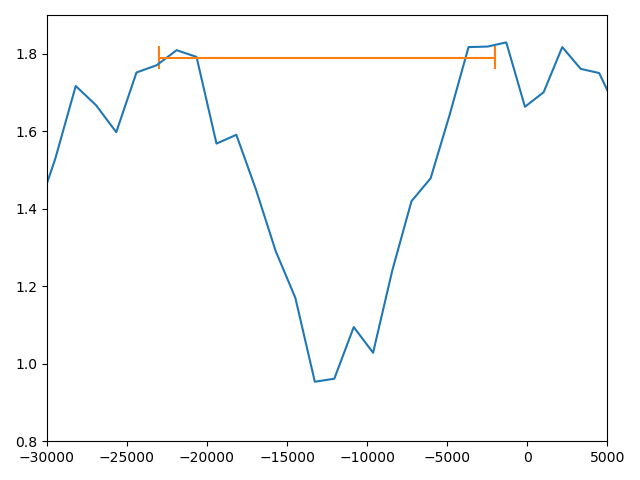

In [137]:
lambda_SiII_6355 = 6371.359
lambda_CaII_IRT = 8662.14

vel_rf = velocity_rf(wv/(1+z), lambda_SiII_6355)
norm_flux = fl/np.nanmedian(fl)
norm_flux_unc = fl_unc/np.nanmedian(fl)

fig, ax = plt.subplots()
ax.plot(vel_rf, norm_flux)
ax.errorbar([-23000, -2000],[1.79, 1.79],[0.03, 0.03])
ax.set_xlim(-30000, 5000)
ax.set_ylim(0.8, 1.9)
fig.tight_layout()

In [141]:
theta = (1.79, 1.79, -10000, 16, -800)
# theta = [-2.20144517e+04,  1.58635773e+01, -8.71247839e+02]

line_region = np.where((vel_rf > -24000) & 
                       (vel_rf < 0))
lnlike_gaussian_abs(theta, -23000, -2000, vel_rf[line_region], 
                    norm_flux[line_region], 
                    delta_vel_components=[velocity_rf(6371.359, 6347.103)], 
                    flux_unc = norm_flux_unc[line_region])


#Si II 6355
# velocity_rf(6371.359, 6347.103)
#Ca II IRT
# velocity_rf(8662.14, 8542.09),
# velocity_rf(8662.14, 8498.02)

-55.17497715887692

In [142]:
ml_res = minimize(neg_lnlike_gaussian_abs, (1.79, 1.79, -12000, 16, -3000), 
                  method='Powell', # Powell method does not need derivatives
                  args=(-23000, -2000, 
                        vel_rf[line_region], norm_flux[line_region], 
                        [velocity_rf(6371.359, 6347.103)], 
                        norm_flux_unc[line_region]))

In [143]:
ml_res.x

array([ 1.80205472e+00,  1.73662680e+00, -1.14594537e+04,  1.63809264e+01,
       -3.73749805e+03])

### MCMC result

In [144]:
initial = np.array([1.79, 1.79, -12000, 16, -3000])
ndim = len(initial)
nwalkers = 100
p1 = [np.array(initial) + 1e-5 * np.random.randn(ndim)
      for i in range(nwalkers)]

In [145]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(-23000, -2000, 
                                      vel_rf[line_region], norm_flux[line_region], 
                                      [velocity_rf(6371.359, 6347.103)], 
                                      norm_flux_unc[line_region], 
                                      1.79, 0.03**2, 1.79, 0.03**2
                                     )
                               )
for sample in sampler.sample(p1, iterations=1500, progress=True):
    continue

100%|████████████████████████████| 1500/1500 [00:09<00:00, 157.88it/s]


<IPython.core.display.Javascript object>


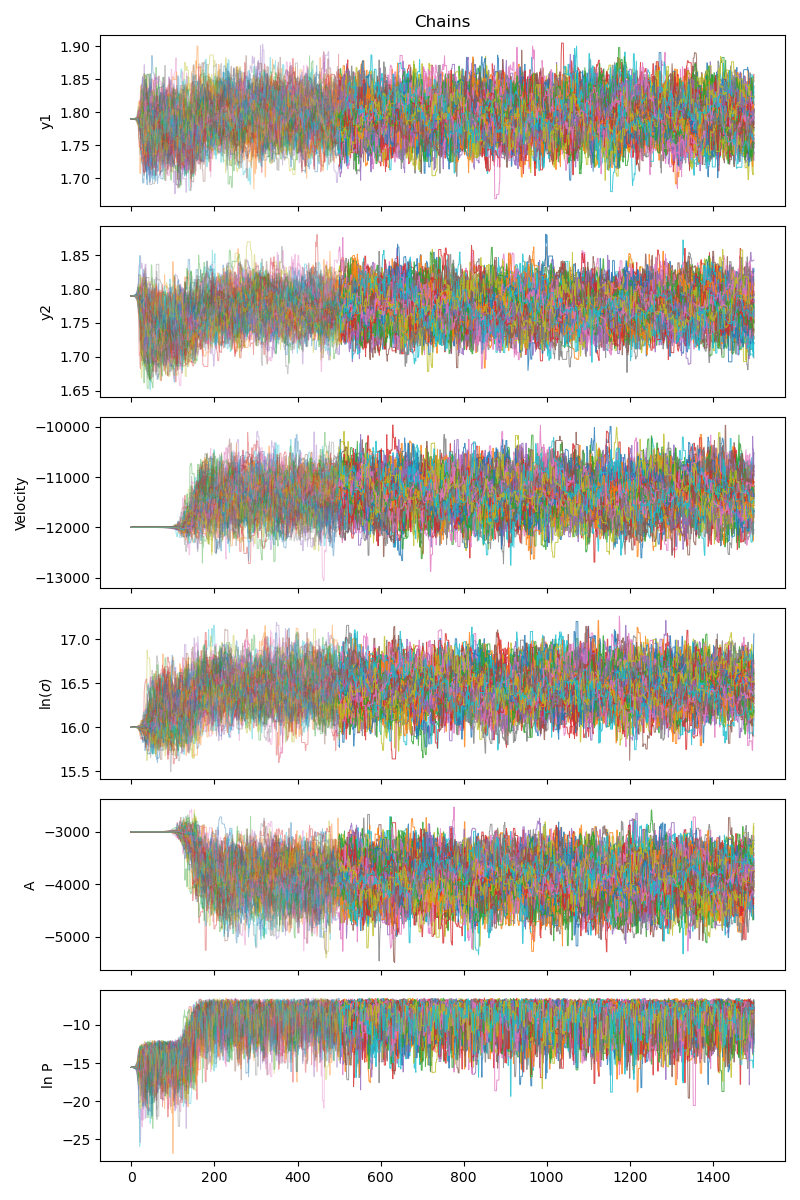

In [146]:
paramsNames = ['y1', 'y2', 'Velocity', 'ln($\sigma$)', 'A']
nburn = 500
plotChains(sampler, nburn, paramsNames)
plt.tight_layout()

In [147]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
samples[-100]

array([ 1.82149660e+00,  1.76815467e+00, -1.12800338e+04,  1.65978279e+01,
       -3.75735278e+03])

<IPython.core.display.Javascript object>


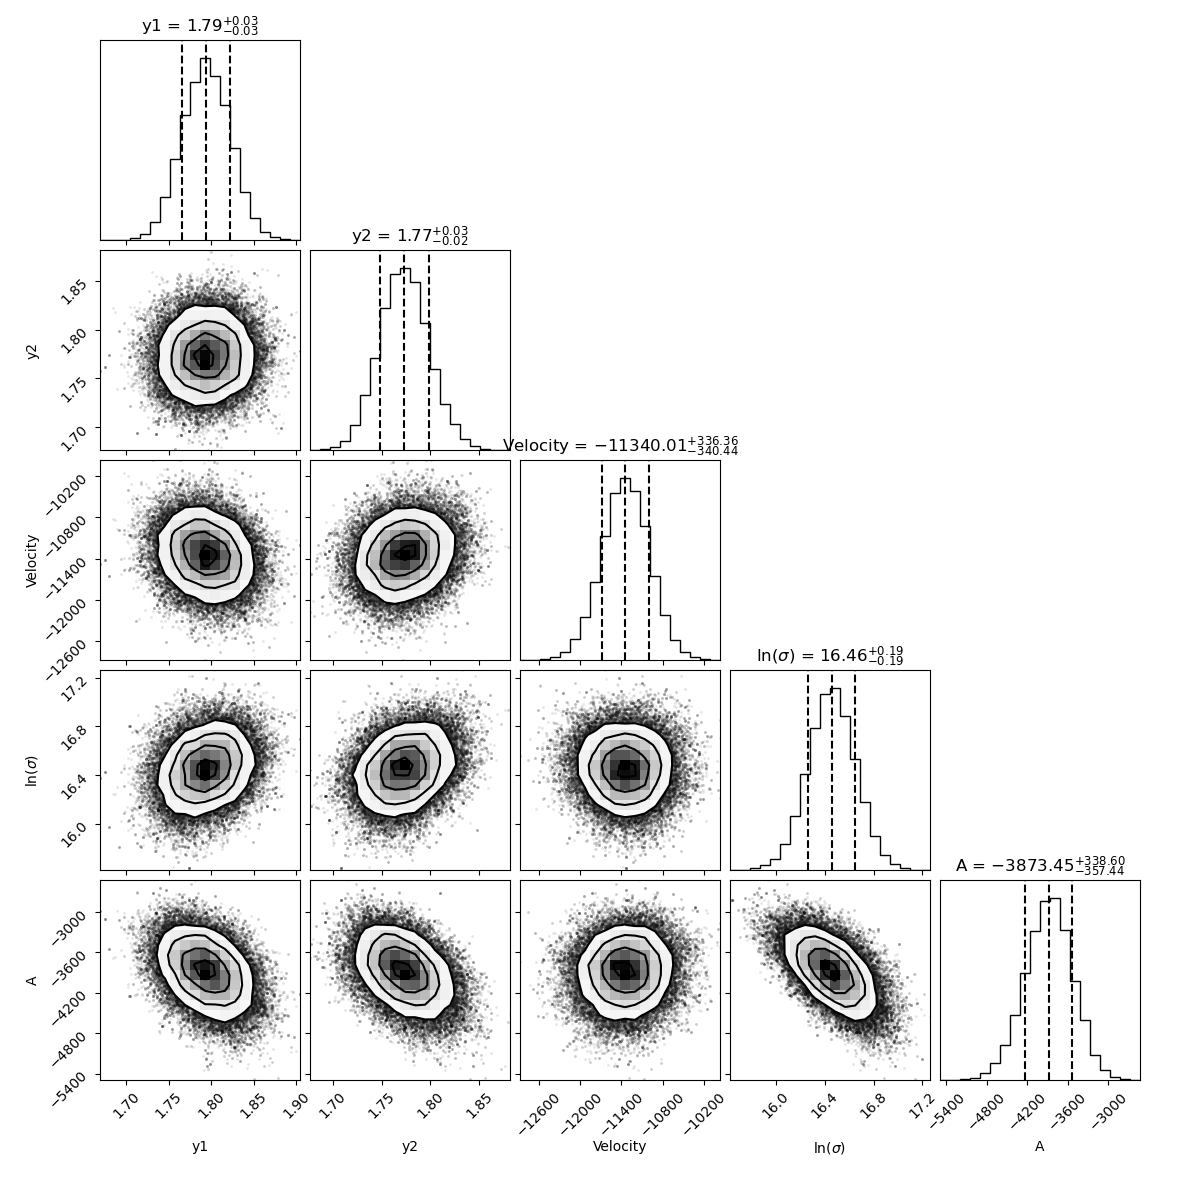

In [148]:
fig = corner.corner(samples, 
                    labels=paramsNames, 
                    quantiles=[0.16,0.50,0.84], 
                    show_titles=True)

<IPython.core.display.Javascript object>


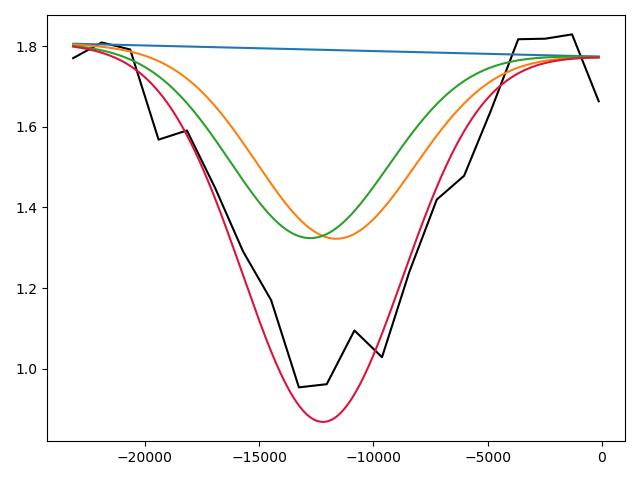

In [150]:
theta = samples[-1234]

y1, y2 = theta[0:2]; x1, x2 = -23000, -2000
m = (y2 - y1)/(x2 - x1)
b = y2 - m*x2
mean, lnvar, amp = theta[2:]
var = np.exp(lnvar)

fig, ax = plt.subplots()

ax.plot(vel_rf[line_region], norm_flux[line_region], 'k')
vel_grid = np.linspace(vel_rf[line_region][0], 
                        vel_rf[line_region][-1], 
                        1000)
ax.plot(vel_grid, m*vel_grid + b)
tot_flux = m*vel_grid + b + calc_gauss(vel_grid, mean, var, amp)
ax.plot(vel_grid, tot_flux)
for delta_vel in [velocity_rf(6371.359, 6347.103)]:
    ax.plot(vel_grid, m*vel_grid + b + calc_gauss(vel_grid, mean-delta_vel, var, amp))
    tot_flux += calc_gauss(vel_grid, mean-delta_vel, var, amp)
    
ax.plot(vel_grid, tot_flux, 'Crimson')
fig.tight_layout()

## HV fit for Ca II IRT

<IPython.core.display.Javascript object>


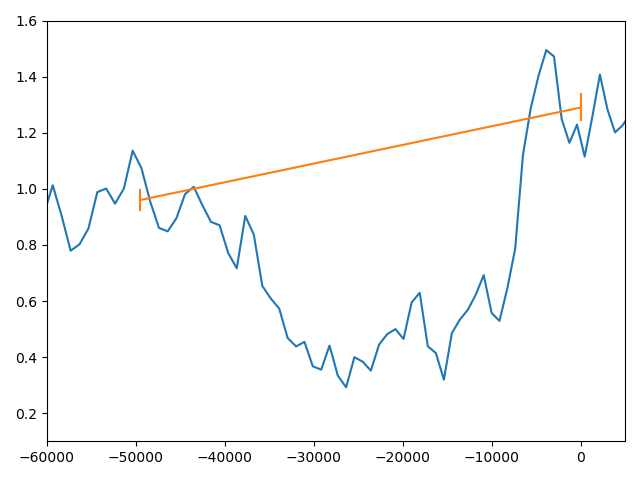

In [165]:
# (x1, y1) = -49500, 0.96 $\pm$0.04 (x2, y2) = 70, 1.29 $\pm$ 0.05

vel_rf = velocity_rf(wv/(1+z), lambda_CaII_IRT)
norm_flux = fl/np.nanmedian(fl)
norm_flux_unc = fl_unc/np.nanmedian(fl)

line_region = np.where((vel_rf > -50000) & 
                       (vel_rf < 500))


fig, ax = plt.subplots()
ax.plot(vel_rf, norm_flux)

ax.errorbar([-49500, 70], [0.96, 1.29], [0.04, 0.05])
ax.set_xlim(-60000, 5000)
ax.set_ylim(0.1,1.6)
fig.tight_layout()

In [166]:
ml_res = minimize(neg_lnlike_gaussian_abs, 
                  (0.96, 1.29, -8200, 17.5, -3500, -20000, 15, -700), 
#                   (-1.041e+04,  1.776e+01, -3.755e+03, -2.413e+04, 1.570e+01, -9.339e+02),
                  method='Powell', # Powell method does not need derivatives
                  args=(-49500, 70, vel_rf[line_region], norm_flux[line_region], 
                        [velocity_rf(8662.14, 8542.09),
                         velocity_rf(8662.14, 8498.02)
                        ], norm_flux_unc[line_region]
                       )
                 )
ml_res.x

array([ 1.01766704e+00,  8.92451351e-01, -1.49890021e+04,  1.88458810e+01,
       -2.90429472e+03, -1.90656986e+04,  1.50188613e+01, -7.05177003e+02])

In [182]:
initial = np.array([0.9, 1.19, -10700, 16.2, -2500, -23500, 16.7, -3200])
ndim = len(initial)
nwalkers = 100
p1 = [np.array(initial) + 1e-5 * np.random.randn(ndim)
      for i in range(nwalkers)]


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(-49500, 70, 
                                      vel_rf[line_region], norm_flux[line_region], 
                                      [velocity_rf(8662.14, 8542.09),
                                       velocity_rf(8662.14, 8498.02)], 
                                      norm_flux_unc[line_region], 
                                      0.96, 0.04**2, 1.29, 0.05**2,
                                      -11340, 700**2 
                                     )
                               )
for sample in sampler.sample(p1, iterations=5000, progress=True):
    continue

100%|█████████████████████████████| 5000/5000 [00:53<00:00, 93.31it/s]


<IPython.core.display.Javascript object>


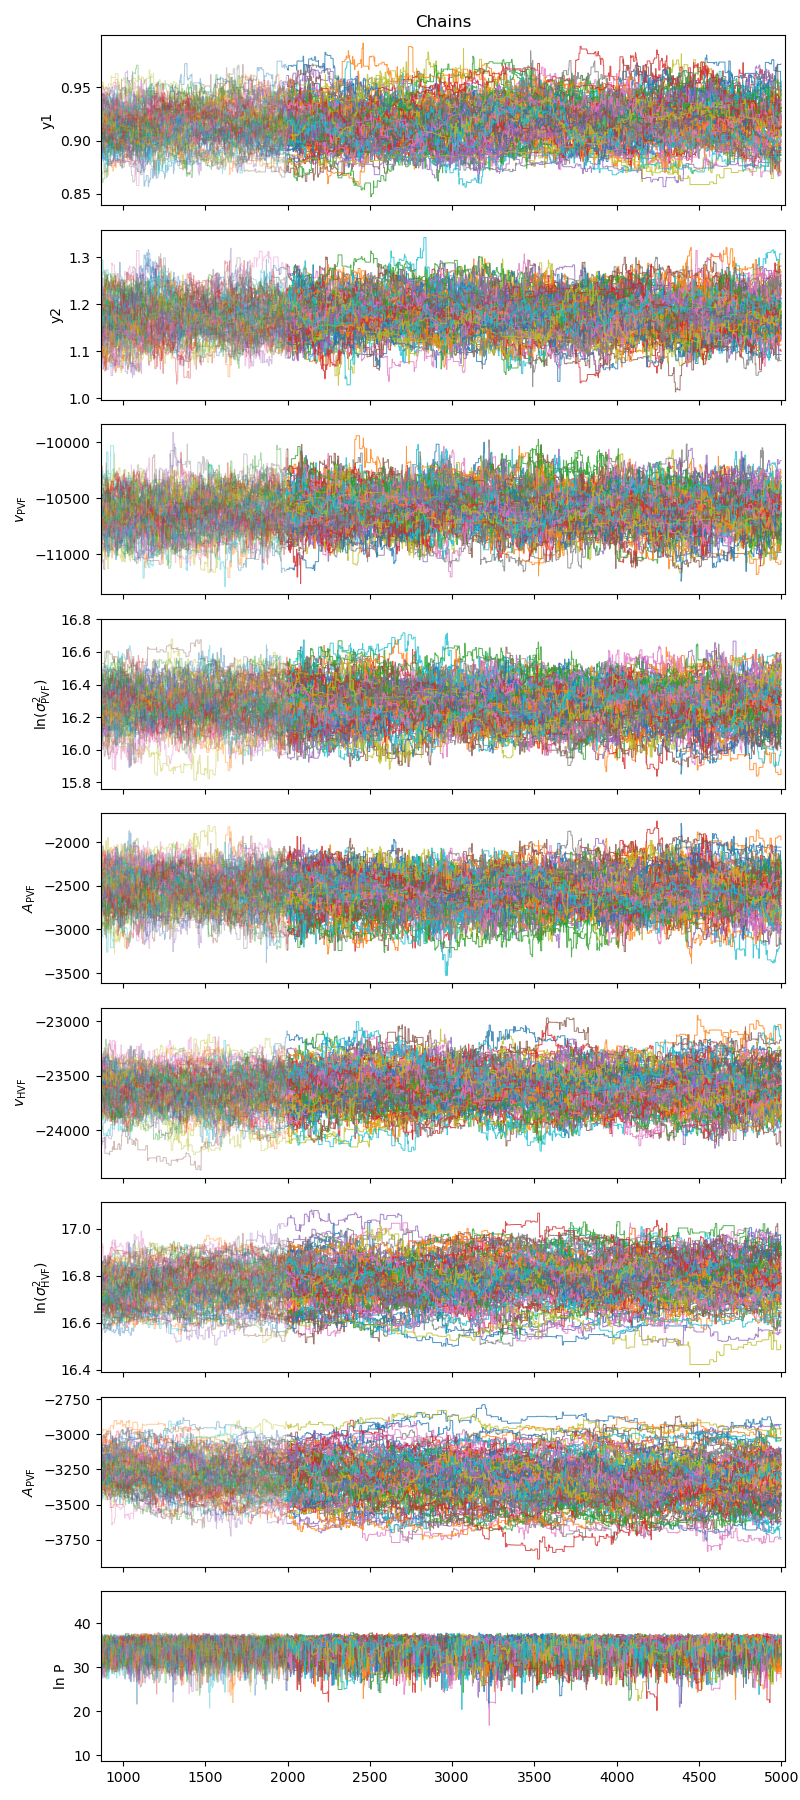

In [183]:
paramsNames = ['y1', 'y2', 
               '$v_\mathrm{PVF}$', 'ln($\sigma_\mathrm{PVF}^2$)', '$A_\mathrm{PVF}$', 
               '$v_\mathrm{HVF}$', 'ln($\sigma_\mathrm{HVF}^2$)', '$A_\mathrm{PVF}$']
nburn = 2000
plotChains(sampler, nburn, paramsNames)
plt.tight_layout()

<IPython.core.display.Javascript object>


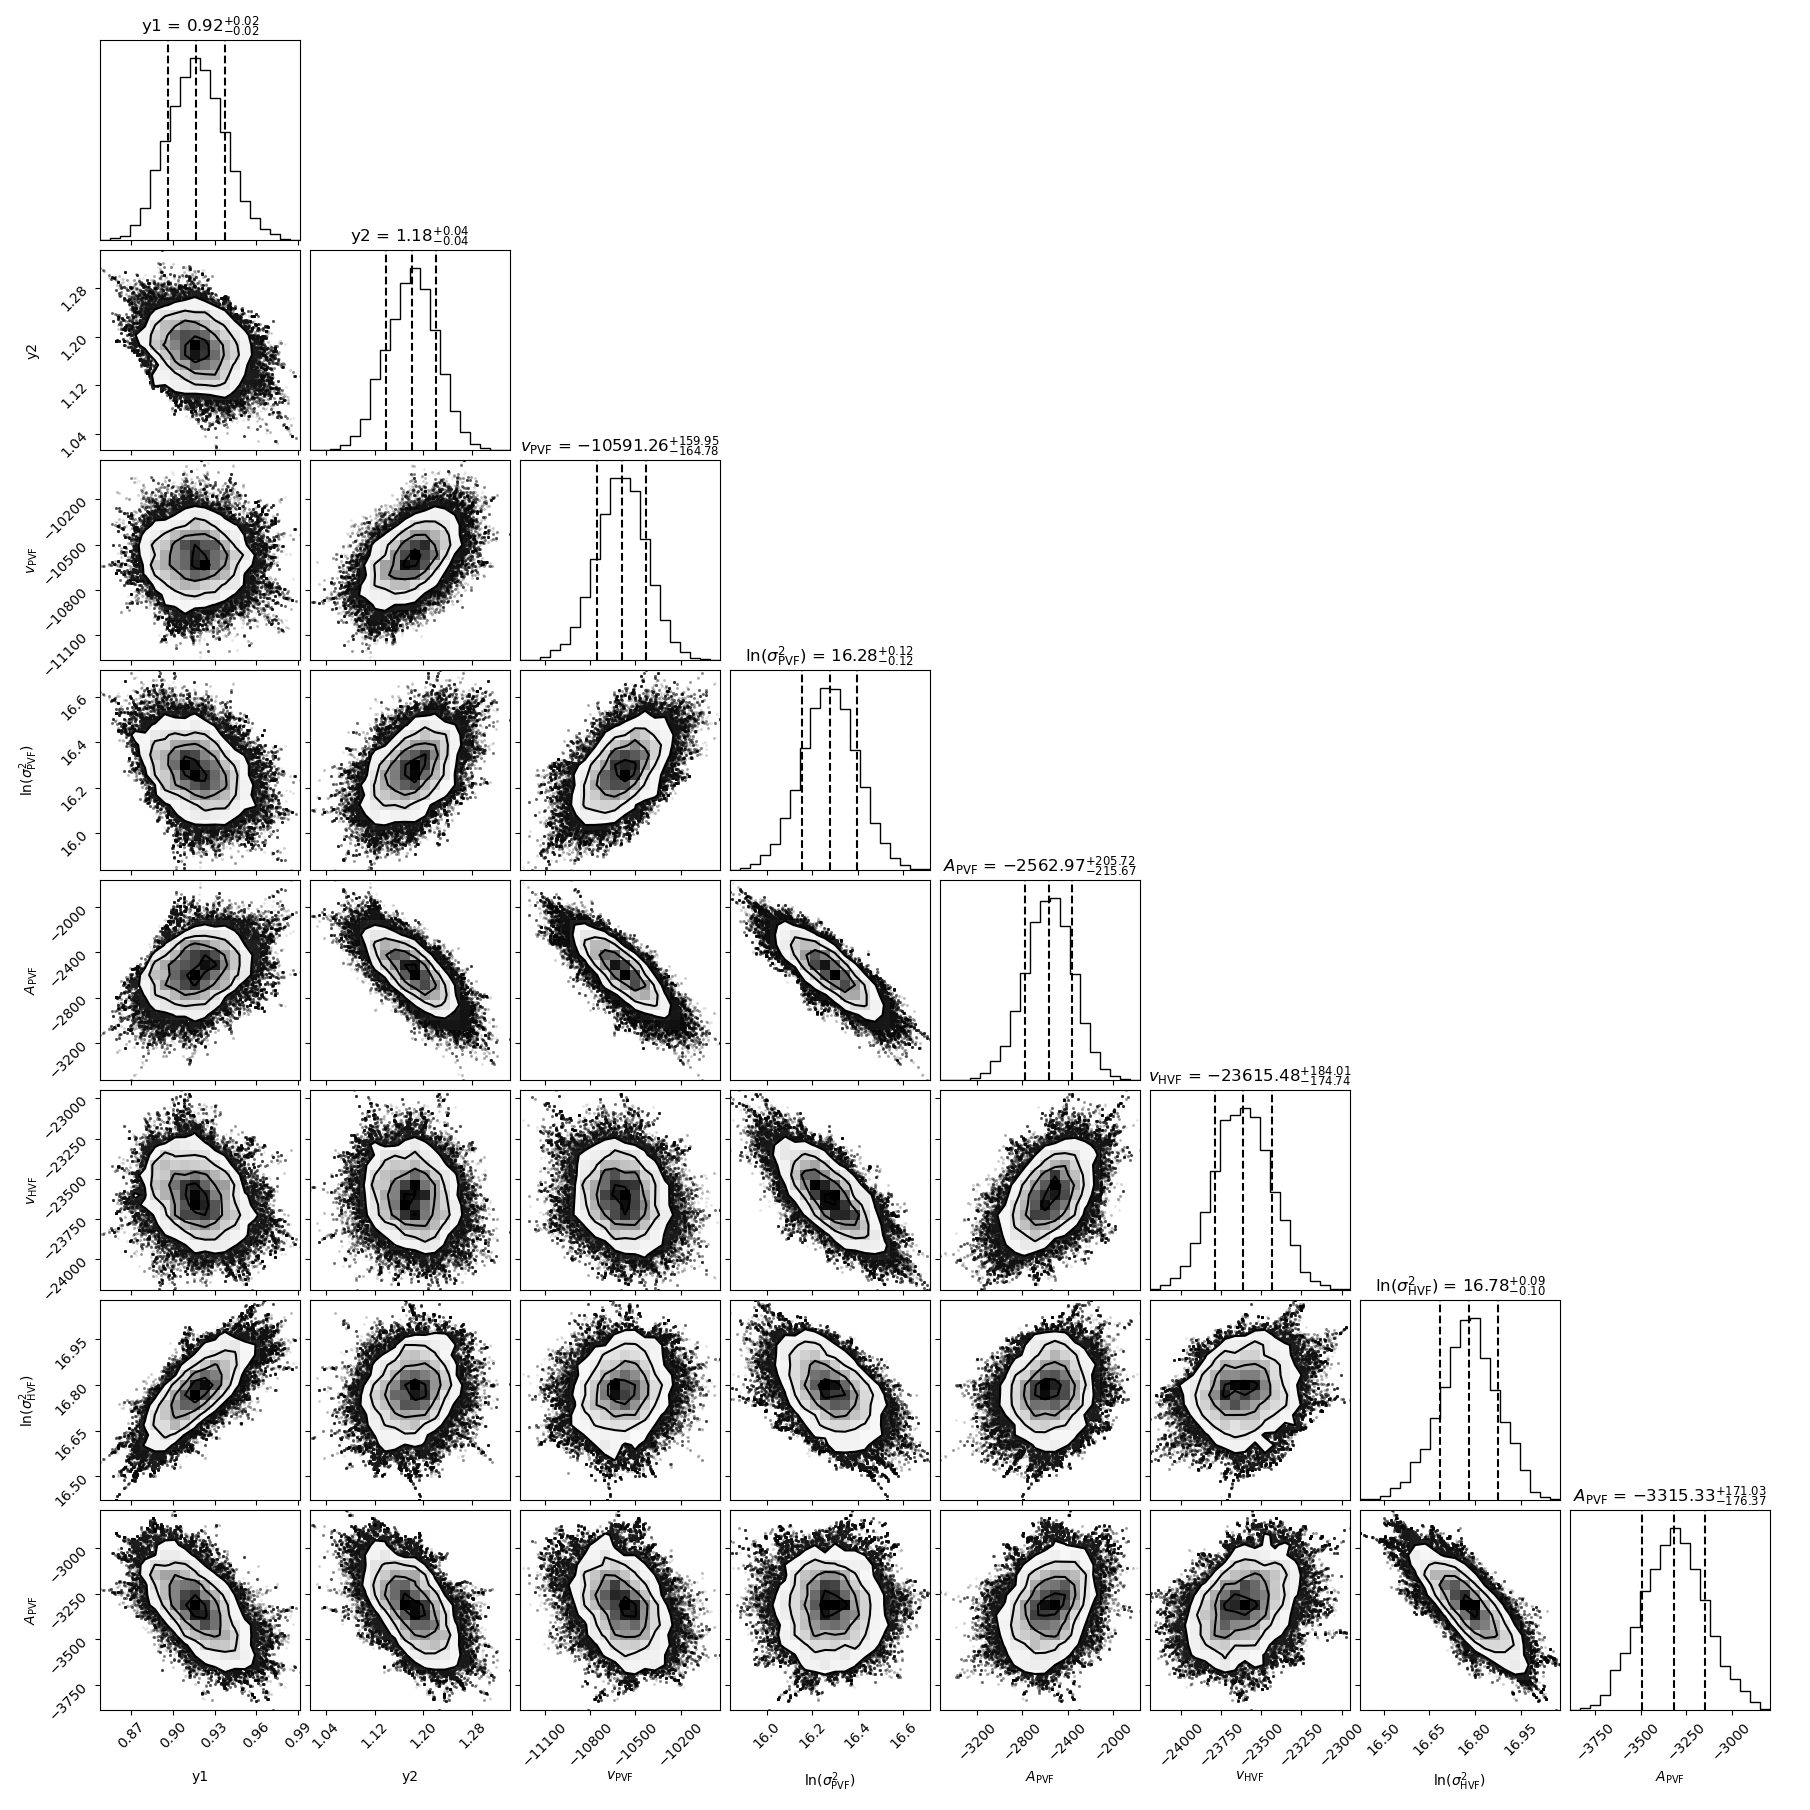

In [184]:
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))
fig = corner.corner(samples, 
                    labels=paramsNames, 
                    quantiles=[0.16,0.50,0.84], 
                    show_titles=True)

<IPython.core.display.Javascript object>


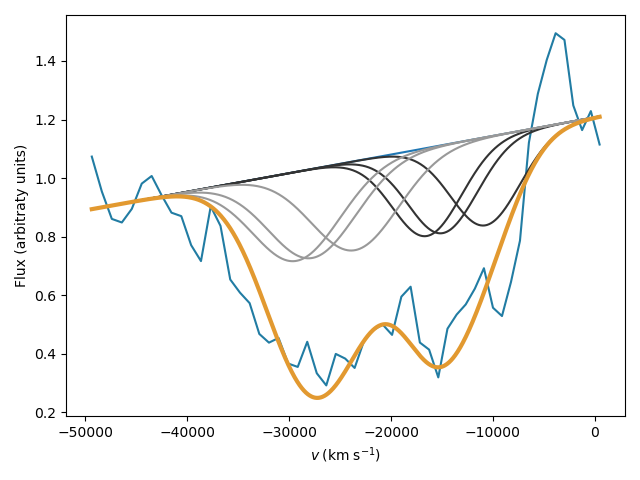

[ 8.93065778e-01  1.20787295e+00 -1.07339843e+04  1.62558633e+01
 -2.55149396e+03 -2.35369342e+04  1.67197453e+01 -3.25538390e+03]


In [195]:
theta = samples[-123]
y1, y2 = theta[0:2]; x1, x2 = -49500, 70
m = (y2 - y1)/(x2 - x1)
b = y2 - m*x2
tot_flux = m*vel_grid + b

col = ['0.2', '0.6']


fig, ax = plt.subplots()
ax.plot(vel_rf[line_region], norm_flux[line_region], '#217CA3')
vel_grid = np.linspace(vel_rf[line_region][0], 
                        vel_rf[line_region][-1], 
                        1000)

ax.plot(vel_grid, tot_flux)

for i in range(int(len(theta)/3)):
    mean, lnvar, amp = theta[3*i+2:3*(i+1) + 2]
    var = np.exp(lnvar)

    tot_flux += calc_gauss(vel_grid, mean, var, amp)
    ax.plot(vel_grid, m*vel_grid + b + calc_gauss(vel_grid, mean, var, amp), 
            color=col[i])
    for delta_vel in [velocity_rf(8662.14, 8542.09),
                      velocity_rf(8662.14, 8498.02)]:
        ax.plot(vel_grid, m*vel_grid + b + calc_gauss(vel_grid, mean-delta_vel, var, amp), 
                color=col[i])
        tot_flux += calc_gauss(vel_grid, mean-delta_vel, var, amp)

ax.plot(vel_grid, tot_flux, '#E29930',lw=3)

ax.set_xlabel('$v\; (\mathrm{km\;s}^{-1})$')
ax.set_ylabel('Flux (arbitraty units)')
fig.tight_layout()

print(theta)
# ax.plot(vel_grid, tot_flux, 'Crimson')
# fig.tight_layout()


# # theta = (-8200, 17.5, -3500, -20000, 15, -700)
# print(theta)
# col = ['0.2', '0.6']

# tot_flux = np.ones_like(vel_rf[line_region])
# for i in range(int(len(theta)/3)):
#     mean, lnvar, amp = theta[3*i: 3*(i+1)]
#     var = np.exp(lnvar)

#     ax.plot(vel_grid, 1 + calc_gauss(vel_grid, mean, var, amp),
#             color=col[i])
#     tot_flux += calc_gauss(vel_rf[line_region], mean, var, amp)
#     for delta_vel in [velocity_rf(8662.14, 8542.09),
#                   velocity_rf(8662.14, 8498.02)]:
#         ax.plot(vel_grid, 1 + calc_gauss(vel_grid, mean-delta_vel, var, amp),
#                 color=col[i])
#         tot_flux += calc_gauss(vel_rf[line_region], mean-delta_vel, var, amp)
# ax.plot(vel_rf[line_region], tot_flux, '#E29930',lw=3)

# fig.tight_layout()

## Build in OOP

In [342]:
class SpectrumSN():
    '''1D optical spectrum'''
    
    def __init__(self, wave, flux, z=0, flux_unc=0):
        self.wave = wave
        self.flux = flux
        self.lambda_rf = wave/(1+z)
        self.res_dict = {}
    
    def measure_vel_and_ew(self, blue_edge, red_edge,
                           fit_region = [],
                           guess = (-10000, 15, -1000),
                           lambda_0 = 6562.85,
                           line_name = 'Halpha',
                           delta_vel = []):
        '''Measure the velocity and equivalent width'''
        
        if len(fit_region) == 0:
            fit_region = [blue_edge[0], red_edge[0]]
            
        norm_flux = divide_continuum(self.lambda_rf, self.flux, 
                                     blue_edge, red_edge)
        v_rf = velocity_rf(self.lambda_rf, lambda_0)
        line = np.where((self.lambda_rf >= fit_region[0]) & 
                        (self.lambda_rf <= fit_region[1]))
        
        vel_fit = minimize(neg_lnlike_gaussian_abs, guess, method='Powell',
                           args=(v_rf[line], norm_flux[line], delta_vel))
        v_absorb = vel_fit.x[0]
        beta = vel_fit.x[2]*(len(delta_vel)+1)/2.99792458e5
        ew = lambda_0*(1-np.sqrt((1+beta)/(1-beta)))
        
        self.res_dict[line_name] = (v_absorb, ew)
    
    def si_6355(self, blue_edge, red_edge, 
                fit_region = [],
                guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                           fit_region = fit_region,
                           guess = guess,
                           lambda_0 = 6371.359,
                           line_name = 'Si6355',
                           delta_vel = [velocity_rf(6371.359, 6347.103)])
    
    def si_5972(self, blue_edge, red_edge, 
            fit_region = [],
            guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5978.929,
                                line_name = 'Si5972',
                                delta_vel = [velocity_rf(5978.929, 5957.561)])
    def si_5669(self, blue_edge, red_edge, 
            fit_region = [],
            guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5669.562,
                                line_name = 'Si5669',
                                delta_vel = [])

    def si_5048(self, blue_edge, red_edge, 
            fit_region = [],
            guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5055.981,
                                line_name = 'Si5048',
                                delta_vel = [velocity_rf(5055.981, 5041.026)])

    def si_4130(self, blue_edge, red_edge, 
                fit_region = [],
                guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 4130.893,
                                line_name = 'Si4130',
                                delta_vel = [velocity_rf(4130.893, 4128.067)])

    def s_5500(self, blue_edge, red_edge, 
                fit_region = [],
                guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 5647.033,
                                line_name = 'S5500',
                                delta_vel = [velocity_rf(5647.033, 5639.972),
                                             velocity_rf(5647.033, 5606.151),
                                             velocity_rf(5647.033, 5473.620),
                                             velocity_rf(5647.033, 5453.828),
                                             velocity_rf(5647.033, 5432.815)
                                            ])
    
    def ca_IRT(self, blue_edge, red_edge,
               fit_region = [],
               guess = (-10000, 15, -1000)):
        self.measure_vel_and_ew(blue_edge, red_edge,
                                fit_region = fit_region,
                                guess = guess,
                                lambda_0 = 8662.14,
                                line_name = 'CaII IRT',
                                delta_vel = [velocity_rf(8662.14, 8542.09),
                                             velocity_rf(8662.14, 8498.02)
                                            ])


In [388]:
minus0 = SpectrumSN(wv, fl, z=z)

In [390]:
minus0.si_6355((5933, 9.67), (6330,8.12))


In [391]:
minus0.si_5972((5648, 10.08), (5870,10.1))

In [370]:
minus0.s_5500((5115, 1.2e-14), (5552,1.11e-14))

In [392]:
minus0.res_dict

{'Si5972': (-11041.97854341314, 26.369406404108968),
 'Si6355': (-11157.174751619928, 118.91598260684479)}

## Helper Functions

In [59]:
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=None):
    '''Plot individual chains from the emcee MCMC sampler
    
    Parameters
    ----------
    sampler : emcee EnsembleSampler object
        emcee affine-invariant multi-chain MCMC sampler
    
    nburn : int
        number of "burn-in" steps for the MCMC chains
    
    paramsNames : list
        names of the parameters to be shown
    
    nplot : int (default=None)
        number of chains to show in the visualization.
        In instances where the number of chains is 
        very large (>> 100), then it can be helpful to 
        downsample to provide more clarity.
    
    Returns
    -------
    ax : maptlotlib axes object
        multi panel plot showing the evoltion of 
        each chain for the parameters in the model
    
    '''
    
    Nparams = len(paramsNames)
    nwalkers = sampler.get_chain().shape[1]
    
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    if nplot is None:
        nplot=nwalkers
    selected_walkers = np.random.choice(range(nwalkers), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.get_chain()[:nburn,w,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.get_chain(discard=nburn)[:,w,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.get_log_prob()[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.get_log_prob(discard=nburn)[:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax